# Spectrum analysis with Gammapy (run pipeline)

In this tutorial we will learn how to perform a 1d spectral analysis.

We will use a "pipeline" or "workflow" class to run a standard analysis. If you're interested in implementation detail of the analysis in order to create a custom analysis class, you should read ([spectrum_analysis.ipynb](spectrum_analysis.ipynb)) that executes the analysis using lower-level classes and methods in Gammapy. 

In this tutorial we will use the folling Gammapy classes:

- [gammapy.data.DataStore](http://docs.gammapy.org/dev/api/gammapy.data.DataStore.html) to load the data to 
- [gammapy.scripts.SpectrumAnalysisIACT](http://docs.gammapy.org/dev/api/gammapy.scripts.SpectrumAnalysisIACT.html) to run the analysis

We use 4 Crab observations from H.E.S.S. for testing.

## Setup

As usual, we'll start with some setup for the notebook, and import the functionality we need.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from gammapy.data import DataStore
from gammapy.scripts import SpectrumAnalysisIACT
from gammapy.catalog import SourceCatalogGammaCat

# Convenience classes to define analsys inputs
# At some point we'll add a convenience layer to run the analysis starting from a plain text config file.
from gammapy.utils.energy import EnergyBounds
from gammapy.maps import Map
from gammapy.spectrum import models
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u

## Select data

First, we select and load some H.E.S.S. data (simulated events for now). In real life you would do something fancy here, or just use the list of observations someone send you (and hope they have done something fancy before). We'll just use the standard gammapy 4 crab runs.

In [2]:
# TODO: Replace with public data release
store_dir = '$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2'
data_store = DataStore.from_dir(store_dir)
obs_id = data_store.obs_table['OBS_ID'].data
print("Use observations {}".format(obs_id))

obs_list = data_store.obs_list(obs_id)

Use observations [23523 23526 23559 23592]


## Configure the analysis

Now we'll define the input for the spectrum analysis. It will be done the python way, i.e. by creating a config dict containing python objects. We plan to add also the convenience to configure the analysis using a plain text config file.

In [4]:
crab_pos = SkyCoord.from_name('crab')
on_region = CircleSkyRegion(crab_pos, 0.15 * u.deg)

model = models.LogParabola(
    alpha = 2.3,
    beta = 0,
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

flux_point_binning = EnergyBounds.equal_log_spacing(0.7, 30, 5, u.TeV)



(<matplotlib.figure.Figure at 0x7f060e655b70>,
 None)

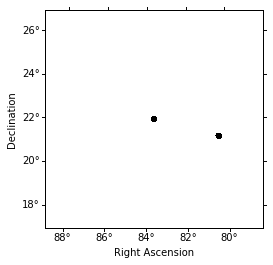

In [15]:
exclusion_mask = Map.create(skydir=crab_pos, width=(10, 10), binsz=0.02)

gammacat = SourceCatalogGammaCat()

regions = []
for source in gammacat:
    if not exclusion_mask.geom.contains(source.position):
        continue
    region = CircleSkyRegion(source.position, 0.15 * u.deg)
    regions.append(region)
    
exclusion_mask.data = exclusion_mask.geom.region_mask(regions, inside=False)
exclusion_mask.plot()

In [16]:
config = dict(
    outdir = None,
    background = dict(
        on_region=on_region,
        exclusion_mask=exclusion_mask,
        min_distance = 0.1 * u.rad,
    ),
    extraction = dict(containment_correction=False),
    fit = dict(
        model=model,
        stat='wstat',
        forward_folded=True,
        fit_range = flux_point_binning[[0, -1]]
    ),
    fp_binning=flux_point_binning
)

## Run the analysis

TODO: Clean up the log (partly done, get rid of remaining useless warnings)

In [17]:
ana = SpectrumAnalysisIACT(
    observations=obs_list,
    config=config,
)
ana.run()

/home/hfm/adonath/github/adonath/gammapy/gammapy/utils/modeling.py:391: RuntimeWarning: divide by zero encountered in log10
  scale = 10 ** int(np.log10(value))


OverflowError: cannot convert float infinity to integer

## Check out the results

TODO: Nice summary page with all results

In [18]:
print(ana.fit.result[0])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
ana.spectrum_result.plot(
    energy_range=ana.fit.fit_range,
    energy_power=2,
    flux_unit='erg-1 cm-2 s-1',
    fig_kwargs=dict(figsize = (8,8)),
)

## Exercises

Rerun the analysis, changing some aspects of the analysis as you like:

* only use one or two observations
* a different spectral model
* different config options for the spectral analysis
* different energy binning for the spectral point computation

Observe how the measured spectrum changes.